<a href="https://colab.research.google.com/github/JCKaren/Proyecto-Modelos/blob/main/99%20-%20modelo%20soluci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

replace submission_example.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
   296787    296787   4265716 my_submission.csv
   296787    296787   4716673 submission_example.csv
   296787   4565553  59185250 test.csv
   692501  10666231 143732449 train.csv
  1582862  15825358 211900088 total


# Importaciones e Instalaciones necesarias.

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Clase para la generación del modelo.

La clase **StudentPerformanceClassifier** está diseñada para predecir el rendimiento académico de los estudiantes a partir de diversos datos demográficos y socioeconómicos presentados en el dataset. Utiliza el modelo de clasificación **CatBoostClassifier** para realizar las predicciones. La clase implementa un proceso completo de preprocesamiento de datos, que incluye la creación de características a partir de la educación de los padres, el estrato socioeconómico, la matrícula universitaria y otros factores relacionados con los programas académicos y los departamentos de los estudiantes. Además, la clase incluye técnicas de codificación dirigida (target encoding) para mejorar la representación de categorías en las variables. El modelo entrenado se evalúa a través de métricas de clasificación, como el reporte de clasificación, la matriz de confusión, Curva de aprendizaje Loss y Accuracy, y proporciona una visualización de la importancia de las características utilizadas en el modelo.

In [ ]:
class StudentPerformanceClassifier:
    """
    Clasificador de rendimiento académico utilizando CatBoost.

    Esta clase implementa un pipeline de ingeniería de características,
    preprocesamiento y entrenamiento de un modelo de clasificación
    multiclase para predecir el rendimiento académico de estudiantes
    basado en variables socioeconómicas y académicas.
    """

    def __init__(self):
        """
        Inicializa el clasificador con los atributos necesarios.
        """
        self.model = None
        self.feature_importance = None
        self.target_encodings = {}
        self.training_columns = []
        self.categorical_features = []
        self.evals_result = None
        self.df_train = None

    def rendimiento_to_numeric(self, rendimiento):
        """
        Convierte etiquetas de rendimiento a valores numéricos.
        """
        mapping = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
        return mapping.get(rendimiento)

    def create_location_program_features(self, df, target_df=None):
        """
        Crea características estadísticas basadas en programa académico y departamento.
        """
        if target_df is not None and 'RENDIMIENTO_GLOBAL' in target_df:
            target_df = target_df.copy()
            target_df['RENDIMIENTO_NUM'] = target_df['RENDIMIENTO_GLOBAL'].map(self.rendimiento_to_numeric)
            prog_stats = target_df.groupby('ESTU_PRGM_ACADEMICO')['RENDIMIENTO_NUM'].agg(['mean', 'std', 'size']).rename(columns={'size': 'count'})
            dept_stats = target_df.groupby('ESTU_PRGM_DEPARTAMENTO')['RENDIMIENTO_NUM'].agg(['mean', 'std', 'size']).rename(columns={'size': 'count'})
            self.target_encodings['programa'] = prog_stats
            self.target_encodings['departamento'] = dept_stats

        df = df.merge(self.target_encodings['programa'], on='ESTU_PRGM_ACADEMICO', how='left', suffixes=('', '_PROG_STATS'))
        df = df.merge(self.target_encodings['departamento'], on='ESTU_PRGM_DEPARTAMENTO', how='left', suffixes=('', '_DEPT_STATS'))

        df.rename(columns={
            'mean': 'PROG_RENDIMIENTO_MEDIO', 'std': 'PROG_RENDIMIENTO_STD', 'count': 'PROG_COUNT',
            'mean_DEPT_STATS': 'DEPT_RENDIMIENTO_MEDIO', 'std_DEPT_STATS': 'DEPT_RENDIMIENTO_STD', 'count_DEPT_STATS': 'DEPT_COUNT'
        }, inplace=True)

        stat_cols = ['PROG_RENDIMIENTO_MEDIO', 'PROG_RENDIMIENTO_STD', 'PROG_COUNT',
                     'DEPT_RENDIMIENTO_MEDIO', 'DEPT_RENDIMIENTO_STD', 'DEPT_COUNT']
        df[stat_cols] = df[stat_cols].fillna(0)

        return df

    def create_education_features(self, df):
        """
        Genera variables numéricas derivadas del nivel educativo de los padres.
        """
        education_mapping = {
            'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
            'Postgrado': 9, 'No sabe': 4, 'No Aplica': 4, 'No reporta': 4
        }
        df['FAMI_EDUCACIONPADRE_NUM'] = df['FAMI_EDUCACIONPADRE'].map(education_mapping)
        df['FAMI_EDUCACIONMADRE_NUM'] = df['FAMI_EDUCACIONMADRE'].map(education_mapping)
        df['FAMI_EDUCACION_PROMEDIO'] = (df['FAMI_EDUCACIONPADRE_NUM'] + df['FAMI_EDUCACIONMADRE_NUM']) / 2
        df['FAMI_EDUCACION_DIFERENCIA'] = abs(df['FAMI_EDUCACIONPADRE_NUM'] - df['FAMI_EDUCACIONMADRE_NUM'])
        df['FAMI_EDUCACION_MAX'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].max(axis=1)
        df['FAMI_EDUCACION_MIN'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].min(axis=1)
        return df

    def create_economic_features(self, df):
        """
        Genera variables socioeconómicas numéricas a partir de información categórica.
        """
        estrato_mapping = {
            'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3, 'Estrato 4': 4,
            'Estrato 5': 5, 'Estrato 6': 6, 'Sin Estrato': 0, 'No reporta': 3
        }
        matricula_mapping = {
            'Menos de 500 mil': 0, 'Entre 500 mil y menos de 1 millón': 1,
            'Entre 1 millón y menos de 2.5 millones': 2, 'Entre 2.5 millones y menos de 4 millones': 3,
            'Entre 4 millones y menos de 5.5 millones': 4, 'Entre 5.5 millones y menos de 7 millones': 5,
            'Más de 7 millones': 6, 'No pagó matrícula': 0, 'No reporta': 3
        }
        df['FAMI_ESTRATO_NUM'] = df['FAMI_ESTRATOVIVIENDA'].map(estrato_mapping)
        df['MATRICULA_NUM'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(matricula_mapping)
        df['INTERNET_BIN'] = (df['FAMI_TIENEINTERNET'] == 'Si').astype(int)
        df['SCORE_SOCIOECONOMICO'] = (df['FAMI_ESTRATO_NUM'] * 0.4 + df['MATRICULA_NUM'] * 0.4 + df['INTERNET_BIN'] * 0.2)
        return df

    def _preprocess_common(self, df):
        """
        Preprocesamiento común de los datos: limpieza básica, transformación de variables y generación de características.
        """
        cols_to_drop = ['ID', 'coef_1', 'coef_2', 'coef_3', 'coef_4', 'FAMI_TIENEINTERNET.1']
        X = df.drop(columns=cols_to_drop, errors='ignore').copy()
        y = X.pop('RENDIMIENTO_GLOBAL') if 'RENDIMIENTO_GLOBAL' in X.columns else None

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            X[col] = X[col].fillna('No reporta')
        if 'PERIODO' in X.columns:
            X['PERIODO'] = X['PERIODO'].astype(str)

        X = self.create_education_features(X)
        X = self.create_economic_features(X)
        return X, y

    def preprocess_data(self, data, validation_mode=True):
        """
        Prepara los datos para el entrenamiento o validación del modelo.
        """
        X, y = self._preprocess_common(data)

        if validation_mode:
            print("Modo: Validación (dividiendo datos)")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

            X_train = self.create_location_program_features(X_train, pd.concat([X_train, y_train], axis=1))
            X_test = self.create_location_program_features(X_test)

            self.df_train = X_train.copy()
            self.training_columns = X_train.columns
            self.categorical_features = list(X_train.select_dtypes(include=['object', 'category']).columns)

            train_pool = Pool(data=X_train, label=y_train, cat_features=self.categorical_features)
            test_pool = Pool(data=X_test, label=y_test, cat_features=self.categorical_features)
            return train_pool, test_pool
        else:
            print("Modo: Entrenamiento final (usando todos los datos)")
            X = self.create_location_program_features(X, pd.concat([X, y], axis=1))

            self.df_train = X.copy()
            self.training_columns = X.columns
            self.categorical_features = list(X.select_dtypes(include=['object', 'category']).columns)

            train_pool = Pool(data=X, label=y, cat_features=self.categorical_features)
            return train_pool, None

    def train_model(self, train_pool, eval_pool=None):
        """
        Entrena el modelo CatBoost.
        """
        self.model = CatBoostClassifier(
            iterations=3000,
            learning_rate=0.03,
            depth=8,
            l2_leaf_reg=7,
            loss_function='MultiClass',
            eval_metric='Accuracy',
            one_hot_max_size=10,
            random_seed=42,
            task_type='GPU',
            verbose=100,
            early_stopping_rounds=50,
            leaf_estimation_method='Newton'
        )
        self.model.fit(
            train_pool,
            eval_set=eval_pool,
            use_best_model=True if eval_pool is not None else False
        )
        if eval_pool is not None:
            self.evals_result = self.model.get_evals_result()
        self.feature_importance = self.model.get_feature_importance(train_pool)


# Uso de la Clase

In [ ]:
# Cargar datos
data = pd.read_csv('train.csv')

In [ ]:
# Instanciar un clasificador solo para la fase de validación
print("--- Iniciando Fase de Validación ---")
validation_classifier = StudentPerformanceClassifier()

--- Iniciando Fase de Validación ---


In [ ]:
# Preprocesar los datos en modo validación (crea train_pool y test_pool)
train_pool, test_pool = validation_classifier.preprocess_data(data, validation_mode=True)

Modo: Validación (dividiendo datos)


In [ ]:
# Entrenar el modelo de validación pasándole el eval_pool para activar early stopping
print("\n--- Entrenando modelo de validación... ---")
validation_classifier.train_model(train_pool, eval_pool=test_pool)
print("--- Entrenamiento de validación completado. ---")


--- Entrenando modelo de validación... ---
0:	learn: 0.4018177	test: 0.4002238	best: 0.4002238 (0)	total: 52.7ms	remaining: 2m 38s
100:	learn: 0.4314693	test: 0.4271047	best: 0.4271047 (100)	total: 3.22s	remaining: 1m 32s
200:	learn: 0.4393610	test: 0.4329747	best: 0.4329747 (200)	total: 7.92s	remaining: 1m 50s
300:	learn: 0.4435181	test: 0.4361227	best: 0.4361227 (300)	total: 11.4s	remaining: 1m 42s
400:	learn: 0.4465884	test: 0.4381444	best: 0.4382022 (397)	total: 14.3s	remaining: 1m 32s
500:	learn: 0.4490596	test: 0.4387942	best: 0.4388809 (491)	total: 19s	remaining: 1m 34s
600:	learn: 0.4512112	test: 0.4400794	best: 0.4401300 (599)	total: 21.9s	remaining: 1m 27s
700:	learn: 0.4532599	test: 0.4404260	best: 0.4404838 (696)	total: 24.8s	remaining: 1m 21s
800:	learn: 0.4552256	test: 0.4409531	best: 0.4410975 (783)	total: 27.8s	remaining: 1m 16s
bestTest = 0.441234657
bestIteration = 810
Shrink model to first 811 iterations.
--- Entrenamiento de validación completado. ---



--- Curva de Aprendizaje ---


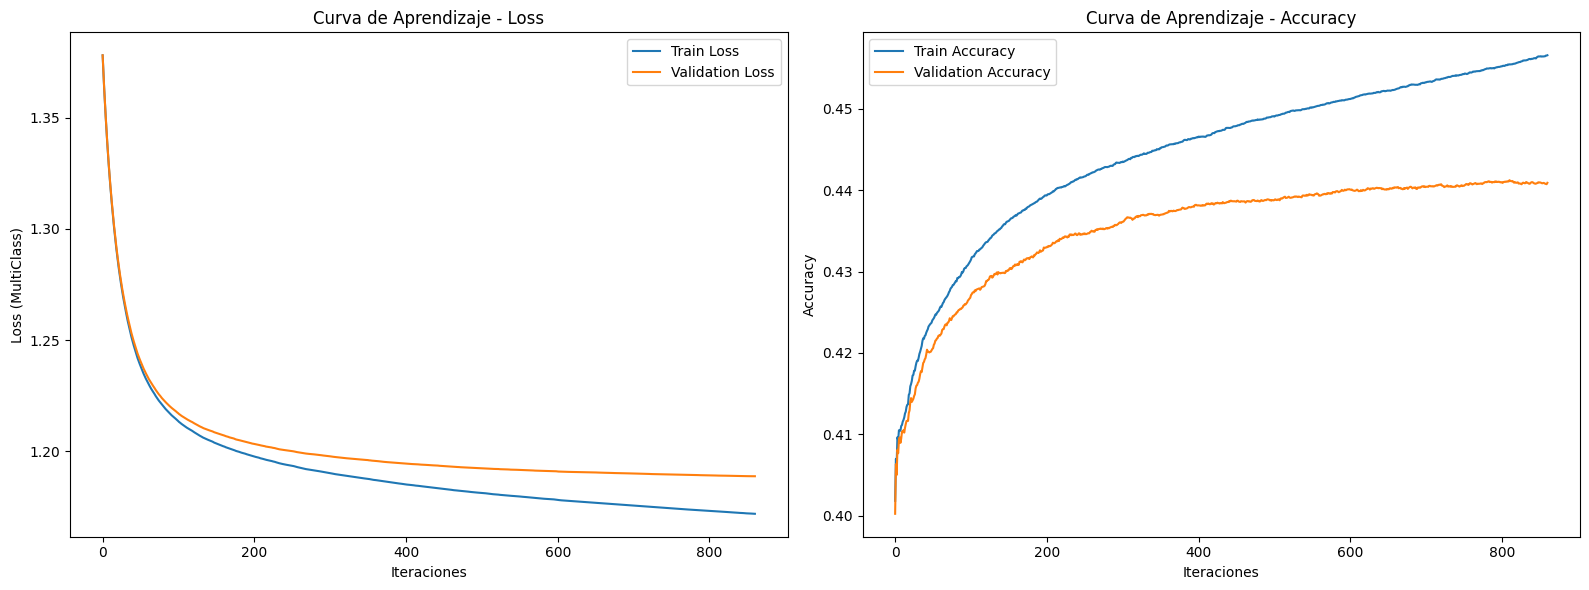

In [ ]:
print("\n--- Curva de Aprendizaje ---")
validation_classifier.plot_learning_curve()

Forma final de los datos para entrenar

In [ ]:
validation_classifier.df_train.head()

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,...,FAMI_ESTRATO_NUM,MATRICULA_NUM,INTERNET_BIN,SCORE_SOCIOECONOMICO,PROG_RENDIMIENTO_MEDIO,PROG_RENDIMIENTO_STD,PROG_COUNT,DEPT_RENDIMIENTO_MEDIO,DEPT_RENDIMIENTO_STD,DEPT_COUNT
0,20183,CONTADURIA PUBLICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,Más de 30 horas,Estrato 2,Si,Secundaria (Bachillerato) incompleta,Si,Si,...,2,2,1,1.8,1.194281,1.013860,31650,1.557140,1.126421,225588
1,20212,FILOSOFIA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,No reporta,No reporta,No reporta,No reporta,No reporta,No reporta,...,3,2,0,2.0,2.087894,1.070863,603,1.557140,1.126421,225588
2,20203,INGENIERIA DE SOFTWARE,BOGOTÁ,Entre 4 millones y menos de 5.5 millones,Entre 21 y 30 horas,Estrato 2,Si,No sabe,Si,Si,...,2,4,1,2.6,1.322936,1.143366,545,1.557140,1.126421,225588
3,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,ATLANTICO,Entre 500 mil y menos de 1 millón,Entre 11 y 20 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,...,3,1,1,1.8,0.662745,0.819791,8839,1.462676,1.135028,32794
4,20183,DERECHO,CAUCA,Entre 2.5 millones y menos de 4 millones,0,Estrato 1,Si,Primaria incompleta,Si,No,...,1,3,1,1.8,1.628156,1.113495,42456,1.269965,1.074659,9216


# Evaluación del Modelo

Una vez realizada la evaluación del modelo, nos podemos dar cuenta que a pesar de la ingeniería de características utilizada aún existe confusión en el mismo para la predicción de las clases medio-alto y medio-bajo, el modelo se desempeña mejor en las clases extremas. Lo cual también se valida en la matrix de confusión.


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.56      0.63      0.59     35124
        bajo       0.47      0.57      0.52     34597
  medio-alto       0.33      0.29      0.31     34324
  medio-bajo       0.34      0.27      0.30     34455

    accuracy                           0.44    138500
   macro avg       0.43      0.44      0.43    138500
weighted avg       0.43      0.44      0.43    138500


Matriz de Confusión:


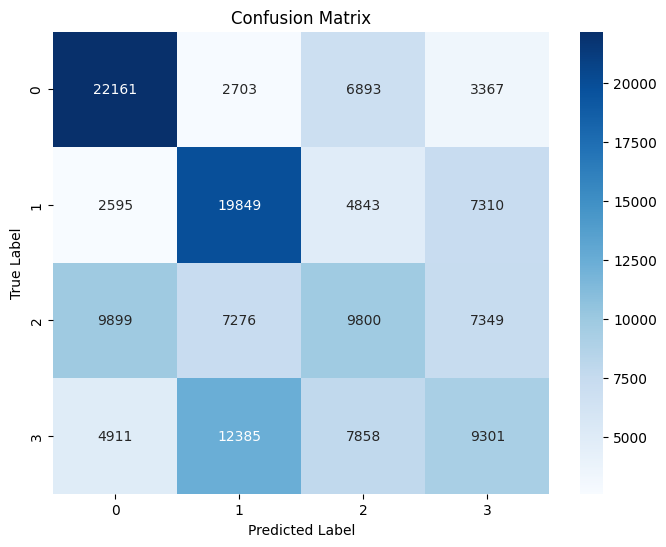

In [ ]:
report, cm = validation_classifier.evaluate_model(test_pool)

print("\nReporte de Clasificación:")
print(report)
print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Prueba con los datos de envío

In [ ]:
# Re-entrenamos un nuevo modelo con TODOS los datos para obtener el mejor rendimiento posible.

print("\n\n--- Iniciando Fase de Entrenamiento Final ---")
test_data_kaggle = pd.read_csv('test.csv')

# Instanciar un nuevo clasificador para el entrenamiento final
final_classifier = StudentPerformanceClassifier()

# Preprocesar TODOS los datos de entrenamiento en modo `validation_mode=False`
final_train_pool, _ = final_classifier.preprocess_data(data, validation_mode=False)

# Entrenar el modelo final (sin eval_pool, ya que usamos todos los datos)
print("\n--- Entrenando modelo final... ---")
final_classifier.train_model(final_train_pool)
print("--- Entrenamiento final completado. ---")




--- Iniciando Fase de Entrenamiento Final ---
Modo: Entrenamiento final (usando todos los datos)

--- Entrenando modelo final... ---
0:	learn: 0.4052231	total: 63.6ms	remaining: 3m 10s
100:	learn: 0.4306513	total: 3.46s	remaining: 1m 39s
200:	learn: 0.4382542	total: 6.7s	remaining: 1m 33s
300:	learn: 0.4424881	total: 12.6s	remaining: 1m 52s
400:	learn: 0.4453271	total: 15.8s	remaining: 1m 42s
500:	learn: 0.4480072	total: 19.1s	remaining: 1m 35s
600:	learn: 0.4502556	total: 24.2s	remaining: 1m 36s
700:	learn: 0.4518960	total: 27.4s	remaining: 1m 29s
800:	learn: 0.4535755	total: 30.7s	remaining: 1m 24s
900:	learn: 0.4551394	total: 34.5s	remaining: 1m 20s
1000:	learn: 0.4567292	total: 38.8s	remaining: 1m 17s
1100:	learn: 0.4580953	total: 42s	remaining: 1m 12s
1200:	learn: 0.4593112	total: 45.2s	remaining: 1m 7s
1300:	learn: 0.4607552	total: 50.2s	remaining: 1m 5s
1400:	learn: 0.4618339	total: 53.4s	remaining: 1m
1500:	learn: 0.4633213	total: 56.7s	remaining: 56.6s
1600:	learn: 0.4644794

In [ ]:
# Re-entrenamos un nuevo modelo con TODOS los datos para obtener el mejor rendimiento posible.
print("\n\n--- Iniciando Fase de Entrenamiento Final ---")
X_test = pd.read_csv('test.csv')



--- Iniciando Fase de Entrenamiento Final ---


In [ ]:
#Hacer y guardar predicciones
results = final_classifier.save_predictions(X_test, 'my_submission.csv')

Predicciones guardadas en 'my_submission.csv'


In [ ]:
results

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto


In [ ]:
print(data['RENDIMIENTO_GLOBAL'].value_counts())

RENDIMIENTO_GLOBAL
alto          175619
bajo          172987
medio-bajo    172275
medio-alto    171619
Name: count, dtype: int64


# Envío para la competencia en Kaggle

In [ ]:
!head my_submission.csv
!kaggle competitions submit -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia -f my_submission.csv -m "version final del catboost"

ID,RENDIMIENTO_GLOBAL
550236,bajo
98545,medio-alto
499179,alto
782980,bajo
785185,bajo
58495,bajo
705444,alto
557548,alto
519909,bajo
100% 4.07M/4.07M [00:00<00:00, 5.59MB/s]
Successfully submitted to UDEA/ai4eng 20251 - Pruebas Saber Pro Colombia